############################################# SCHRODINGER EQUATION ###########################################################################
#
Continuous time-independent Schrodinger Equation ¨ Consider the one dimensional quantum harmonic oscillator defined by the Hamiltonian:
#𝐻 = 𝑝ˆ2 + 𝜔2𝑞ˆ2
(a) Write a program to compute the first 𝑘 eigenvalues 𝐸𝑘 and eigenvectors |Ψ𝑘 ⟩.
(b) How would you rate your program in terms of the priorities we introduced in class for good scientific
software development (Correctness, Stability, Accurate discretization, Flexibility, Efficiency)?
#
###############################################################################################################################################

In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from typing import Union
import os
import scipy

# VISUAL OPTIONS
# print options for only 2 decimals
np.set_printoptions(precision=1)

# Eigenvalues and eigenfuncitons #

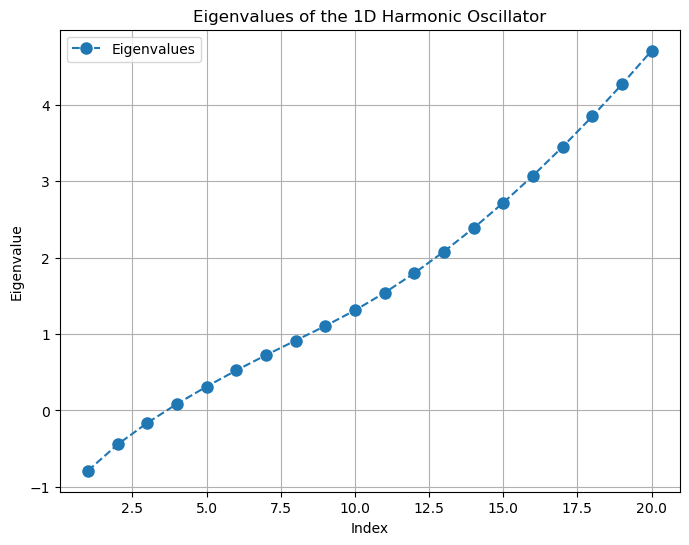

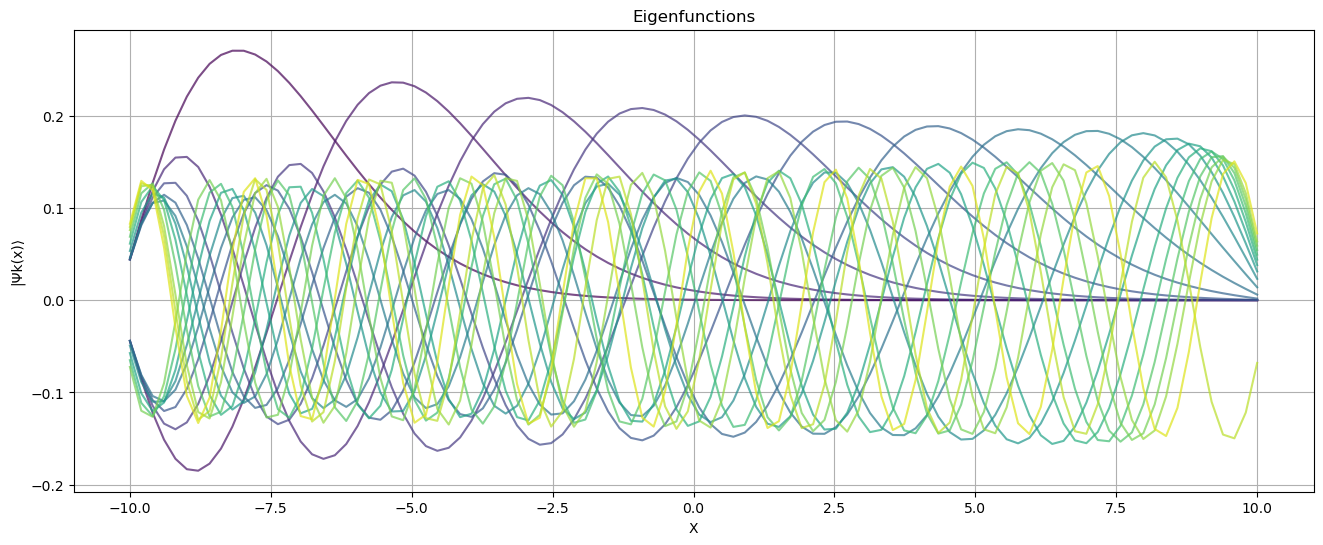

File succesfully saved to ./Results.


In [ ]:
### EIGENVALUES AND EIGENFUNCTIONS

# Define the kinetic and potential matrices
def K(a: Union[int, float], b: Union[int, float], N: int):
    
    ##  This function creates the kinetic matrix for the 1D harmonic oscillator
    ##  (to the 2nd order) given the space discretization.
    
    # Check for acceptable values of the input data
    if not isinstance(a, (int,float)):
        raise TypeError('a must be a real number!')
    
    if not isinstance(b, (int,float)):
        raise TypeError('b must be a real number!')
    
    if not isinstance(N, int):
        raise TypeError('N must be an integer number!')
    
    if b < a:
        print('b must be bigger than a.')
        exit(1)
    
    # Define the spatial discretization
    deltaX = (b - a) / N
    
    # Initialize the matrix
    mat = np.zeros((N,N))
    
    # Fill the diagonal values
    np.fill_diagonal(mat, 2)
    
    # Fill the lower and upper diagonal
    for i in range(N-1):
            mat[i,i+1] = -1
            mat[i+1,i] = -1
    
    # Multiply by the coefficient
    K = (1 / (2 * deltaX**2)) * mat

    return K    

def V(a: Union[int, float], b: Union[int, float], N: int, omega: Union[int,float]):
    
    ##  This function creates the potential matrix for the 1D harmonic oscillator
    ##  (to the 2nd order) given the space discretization and 𝜔.
    
    # Check for acceptable values of the input data
    if not isinstance(a, (int,float)):
        raise TypeError('a must be a real number!')
    
    if not isinstance(b, (int,float)):
        raise TypeError('b must be a real number!')
    
    if not isinstance(N, int):
        raise TypeError('N must be an integer number!')
    
    if not isinstance(omega, (int,float)):
        raise TypeError('omega must be a real number!')
        
    if b < a:
        print('b must be bigger than a.')
        exit(1)
    
    # Define the spatial discretization
    deltaX = (b - a) / N
    
    # Define the spatial steps
    x_vals = np.linspace(a + deltaX, b - deltaX, N)
    
    # Initialize the matrix
    mat = np.zeros((N,N))
    
    # Fill the diagonal values
    np.fill_diagonal(mat, x_vals)
    
    # Multiply by the coefficient
    V = (omega**2 / 2)  * mat

    return V

def E_psi(K: np.array,V: np.array, k: int):
    
    ##  This function calculates the first k eigenvalues E_k
    ##  and eigenfunctions Psi_k of the 1D harmonic oscillator 
    ##  through the finite difference method at 2nd order.
    
    # Check for acceptable values of the input data
    if K.shape != V.shape:
        print('K and V must be square matrices of the same size.')
        exit(1)
    '''
    if not isinstance(K, np.array):
        raise TypeError('K must be a Numpy array!')
    
    if not isinstance(V, np.array):
        raise TypeError('V must be a Numpy array!')
    '''
    if not isinstance(k, int):
        raise TypeError('k must be an integer!')
    
    # Define the sum of the two matrices, S
    S = K + V     # This will be a tridiagonal matrix
    
    # Calculate eigenvalues and eigenvectors
    diag = np.zeros(K.shape[0])
    off_diag = np.zeros(K.shape[0] - 1)
    for i in range(K.shape[0]):
        diag[i] = S[i,i]
        if i < K.shape[0] - 1:          # this is necessary to avoid an index out of range error
            off_diag[i] = S[i,i+1]
    
    # eigh_tridiagonal()'s select= and select_range= options let you compute up to the k-th eigenvalue (and eigenvectors)
    eigvals, eigvec = eigh_tridiagonal(diag, off_diag, eigvals_only=False, select='i', select_range=(0,k-1))    # (0,k-1) because I'm asking to compue the first k eigenvalues and also the zero-th has to be counted
    
    return eigvals, eigvec

def plot_eig(eigvecs, eigvals, a, b, N):
    ##  This function plots the eigenvalues and eigenvectors of the 1D harmonic oscillator.
    
    # TO DO!! PLOT EIGENVALS!!!
    # plot eigenvalues
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(eigvals) + 1), eigvals, 'o--', markersize=8, label='Eigenvalues')
    plt.grid(True)
    plt.title('Eigenvalues of the 1D Harmonic Oscillator')
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.show()
    
    
    # Extract k_max
    k_max = eigvecs.shape[1]
    
    # Define the spatial steps
    x_vals = np.linspace(a, b, N)
    
    plt.figure(figsize=(16, 6))
    
    for k in range(k_max-1):
        plt.plot(x_vals, eigvecs[:, k], label=f'k={k}', alpha=0.7, color=plt.cm.viridis(k / (k_max - 1)))
    
    #plt.legend()
    plt.grid()     
    plt.title('Eigenfunctions')
    plt.xlabel('X')
    plt.ylabel('|Ψk(x)⟩')
    #plt.text(0.9,0.8,f'a={a}\nb={b}')
    
    if not os.path.exists('Results'):
        os.makedirs('Results')
        
    plt.savefig(f'Results/eigenfunctions_k={k_max}.png')
    plt.show()
    print('File succesfully saved to ./Results')

## TEST

# Define the interval [a,b] and the space discretization Deltax = (b - a) / N
a = -10 
b = 10
N = 100
omega = 0.5
k = 20           # number of eigenvalues and eigenvetors to be computed

K = K(a,b,N)
V = V(a,b,N,omega) 
eigvals, eigvecs = E_psi(K,V,k)

test_print = False
if test_print:
    print(K)
    print(V)
    print(eigvals)
    print(eigvecs)
    print(eigvecs[:,0])
    print(eigvecs.shape[1])


plot_eig(eigvecs, eigvals, a, b, N)



In [ ]:
a = np.array([1,8,3,4,5])
print(a[:5])

[1 8 3 4 5]


# Analytical comparison #

In [ ]:
# Define the eigenvalues
def eigval_a(omega, a, b, N, k):
    ##  This function defines the energy eigenvalues for the 1D harmonic oscillator
    #   E_n = h_bar * omega * (n + 1/2)
    #   (h_bar := 1)
    #   and return the first k eigenvalues.
        
    # Define the space discretization (n)
    n = np.linspace(a,b,N)
    
    # Compute eigenvalues
    E_n = omega * (n + 1/2)
    
    return E_n[:k]

def eigenf_a()
    ## CALCULATE EIGENFUNCTIONS FROM THE ANALYTICAL FORMULATION
    # hermnite polinomials
    #   (h_bar := 1)
    #   mass m := 1
    
    # Define the space discretization (n)
    n = np.linspace(a,b,N)
    
    # herm_n(np.sqrt(omega)*x)
    herm = scipy.hermite()
    
    # Psi:
    psi = (1 / np.sqrt(2**n) * np.factorial()) * ((omega / np.pi)**(1/4))*np.exp(-(omega*(x**2)/2))*herm
    
    return psi
    